Here we are using cupy and cudf from RAPIDS-0.19 so we can take advantage of our gpu for training.  This can be swapped back to numpy and pandas with the only lines needing changed is importing data below.

In [19]:
import cupy as np
import cudf as pd
import matplotlib.pyplot as plt

Importing our data from the kaggle dataset.  
Note that cupy does not support np.array(df), instead we must send the df to_dlpack from cudf and load to cupy using fromdlpack, this line must be swapped with the commented out line if using numpy, it should be the only change necessary to use numpy instead of cupy.

In [20]:
train = pd.read_csv('./Dataset/train.csv')
display(train.head())
data = np.fromDlpack(train.to_dlpack())
# data = np.array(train)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split 20% to test set and 80% to train set, also split the labels from each

In [21]:
m, n = data.shape
test_length = int(m * .2)
test = data[0:test_length].T
Y_test = test[0]
X_test = test[1:] / 255.

train = data[test_length:].T
Y_train = train[0]
X_train = train[1:] / 255.

Randomly initialize the parameters

In [22]:
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2

Using ReLU as our activation function for the hidden layer and softmax as the activation function for our output layer.

In [23]:
def ReLU(z):
    return np.maximum(0, z)

def softmax(z):
    e = np.exp(z)
    return e / sum(e)

Here we calculate the derivative of ReLU, which is either one or zero, one if Z>0 or 0 if Z<0, so we can simply return a boolean for this condition

In [25]:
def der_ReLU(Z):
    return Z > 0

We must one hot the labels for use

In [24]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return (one_hot_Y := one_hot_Y.T)

Create the forward and back propogation functions

In [26]:
def forward(w1, b1, w2, b2, X):
    z1 = w1.dot(X) + b1
    a1 = ReLU(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def back(z1, a1, z2, a2, w2, X, Y):
    one_hot_Y = one_hot(Y)
    dz2 = a2 - one_hot_Y
    dw2 = (1 / m) * dz2.dot(a1.T)
    db2 = (1 / m) * np.sum(dz2)
    dz1 = w2.T.dot(dz2) * der_ReLU(z1)
    dw1 = (1 / m) * dz1.dot(X.T)
    db1 = (1 / m) * np.sum(dz1)
    return dw1, db1, dw2, db2    

In [27]:
def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2

Here we create a progress and accuracy meter and create the gradient descent function. 

In [28]:
def get_predictions(a2):
    return np.argmax(a2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def grad_desc(X, Y, iterations, alpha):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2 = forward(w1, b1, w2, b2, X)
        dw1, db1, dw2, db2 = back(z1, a1, z2, a2, w2, X, Y)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, alpha)
        if i % 100 == 0:
            print('Iteration: ', i)
            print('Accuracy: ', get_accuracy(get_predictions(a2), Y))
    return w1, b1, w2, b2

Lets train the model. The alpha used here is very high, but higher values seemed to not only converge faster but also produce a higher accuracy on the test set.

In [59]:
w1, b1, w2, b2 = grad_desc(X_train, Y_train, iterations=1500, alpha = .8)

Iteration:  0
[1 2 4 ... 0 0 0] [5 0 9 ... 7 6 9]
Accuracy:  0.10461309523809524
Iteration:  100
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.852827380952381
Iteration:  200
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.8928571428571429
Iteration:  300
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9035714285714286
Iteration:  400
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9186904761904762
Iteration:  500
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9222023809523809
Iteration:  600
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9248511904761905
Iteration:  700
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9299404761904762
Iteration:  800
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9306845238095238
Iteration:  900
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9341071428571428
Iteration:  1000
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9339583333333333
Iteration:  1100
[5 0 9 ... 7 6 9] [5 0 9 ... 7 6 9]
Accuracy:  0.9372916666666666
Iteration:  1200

Now lets create the functions which allow us to test our model

In [45]:
def make_predictions(X, w1, b1, w2, b2):
    _, _, _, a2 = forward(w1, b1, w2, b2, X)
    predictions = get_predictions(a2)
    return predictions

def test_prediction(index, w1, b1, w2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w1, b1, w2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image.get(), interpolation='nearest')
    plt.show()

Testing model on test set produces 93% accuracy, not perfect but not bad either.

In [60]:
test_predictions = make_predictions(X_test, w1, b1, w2, b2)
get_accuracy(test_predictions, Y_test)

[1 0 1 ... 6 4 5] [1 0 1 ... 6 4 5]


array(0.93238095)

Prediction:  [0]
Label:  0


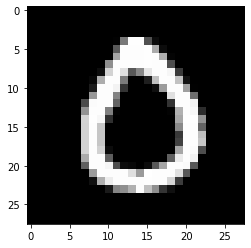

In [61]:
test_prediction(1, w1, b1, w2, b2)